In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

palette = sns.color_palette("coolwarm", 7)
sns.set(style='whitegrid', palette=palette, font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

LABELS = ["Normal", "Fraud"]

# Reading The Data

The dataset that we are going to use can be downloaded from Kaggle. All variables in the data set are numerical. The data has been transformed using a PCA transformation(s) for privacy purposes. The two attributes that have not been changed are Time and Amount. Time includes seconds that have elapsed between each transaction and the first transaction in the dataset.

In [5]:
path = %pwd
df = pd.read_csv(f'{path}/creditcard.csv')
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [6]:
df.shape

(284807, 31)

Data Exploration and Imputation

In [7]:
# 31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. 
# Let's check for missing values:
df.isnull().values.any()

False

In [8]:
#Ensuring there are no categorical values or non-float or non-integer values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

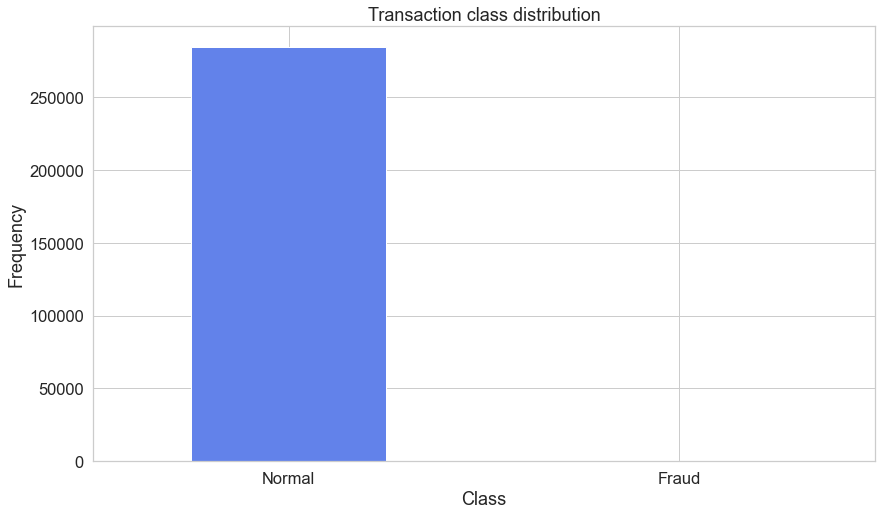

In [9]:
#Plotting transaction distribution across normal and fraud transactions
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [11]:
frauds.shape

(492, 31)

In [12]:
normal.shape

(284315, 31)

In [13]:
# The difference in amount of money used in different transaction classes

frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

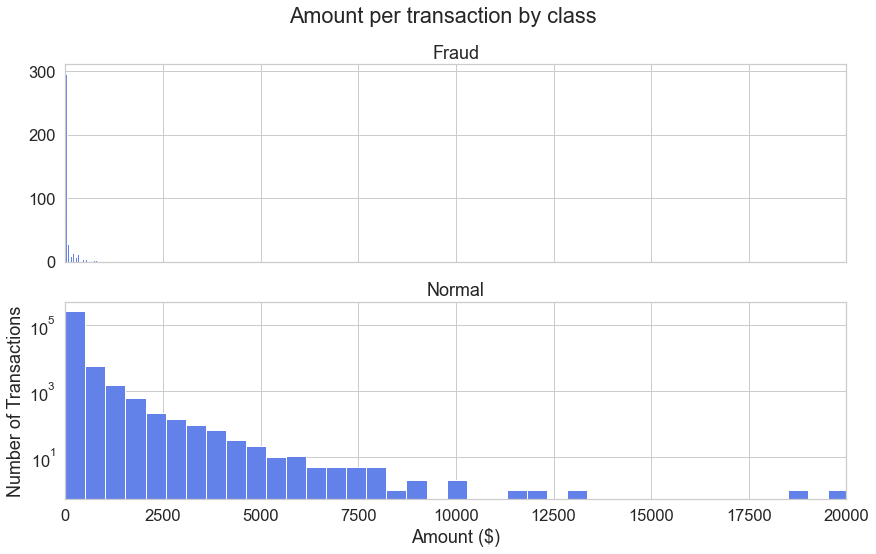

In [15]:
# Graphical representation of amount per transaction by class

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

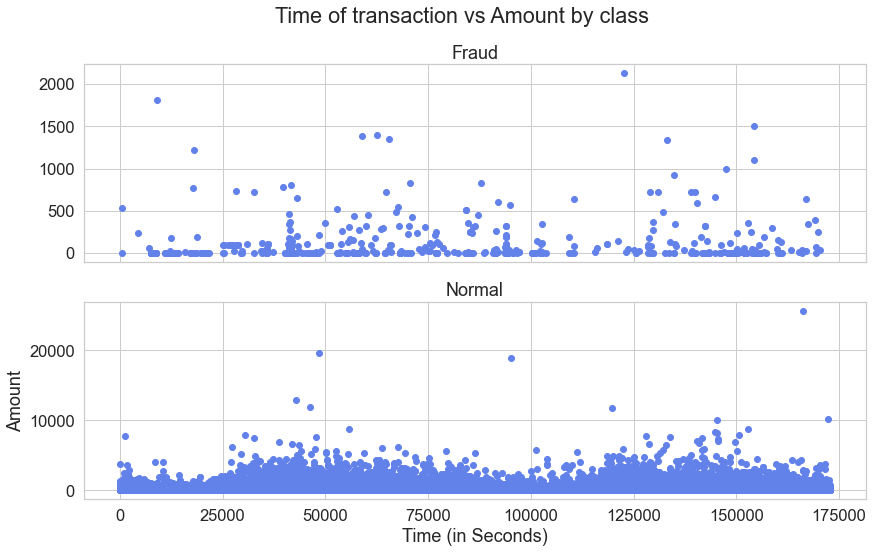

In [16]:
# Understanding/ plotting relationship between time and fraud transactions

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Data Pre-Processing 

In [17]:
# Splitting the data into train, valid and test set

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_valid = sc.fit_transform(X_train_valid)
X_test = sc.transform(X_test)

X_train , X_valid , Y_train , Y_valid = train_test_split(X_train_valid , Y_train_valid , test_size=0.1, random_state=1)

# Building the Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy

In [20]:
print(X_train.shape)
print(Y_train.shape)

(230693, 30)
(230693,)


In [21]:
def create_model(activation='relu', optimizer=Adam, learning_rate=0.5, dropout=0.25):
    model = Sequential()
    # Layers
    model.add(Dense(16, input_dim=30,
                    activation=activation,
                    kernel_initializer='uniform'))
    model.add(Dense(units=18, kernel_initializer='uniform', activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(units=20, kernel_initializer='uniform', activation=activation))
    model.add(Dense(units=24, kernel_initializer='uniform', activation=activation))
    # Last layer
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer='uniform'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer(lr=learning_rate),
                  metrics=['accuracy'])
    
    # finally we have to make sure that the model is returned
    return model

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
______________________________________________________

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid),
                        batch_size=15,
                        epochs=10)

Epoch 1/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 2/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9993
Epoch 3/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 4/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 5/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 6/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 7/10
15380/15380 [==============================] - 22s 1ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0

In [24]:
score = model.evaluate(X_valid, Y_valid, batch_size=15)
print('\nAnd the Score is ', score[1] * 100, '%')

1709/1709 [==============================] - 2s 995us/step - loss: 0.0037 - accuracy: 0.9995

And the Score is  99.95318651199341 %


In [25]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [26]:
import matplotlib.pyplot as plt

In [27]:
epochs = range(1,11)

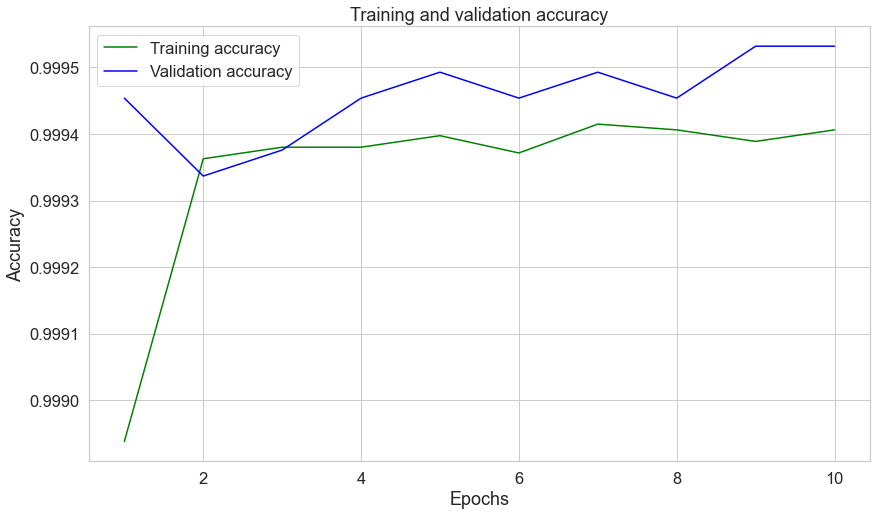

In [28]:
plt.plot(epochs,train_acc,'g',label = 'Training accuracy')
plt.plot(epochs,valid_acc,'b',label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,roc_auc_score)

roc-auc is 0.926


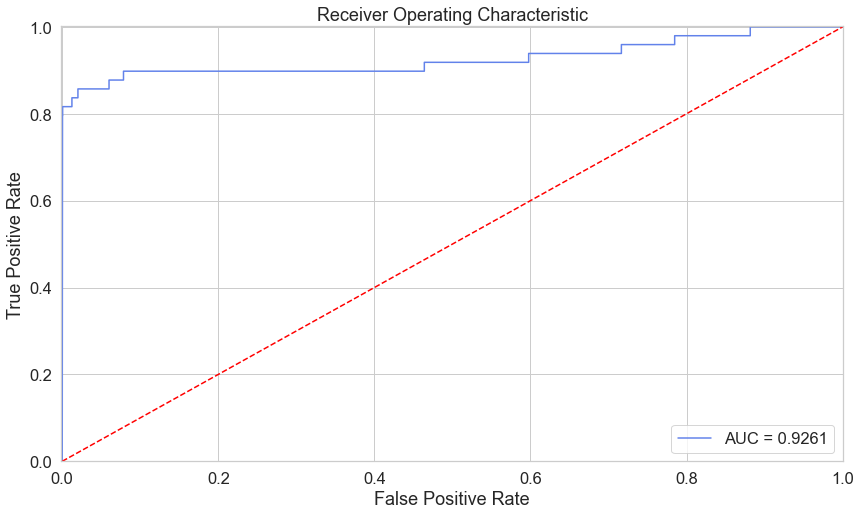

In [30]:
y_pred= model.predict(X_test)

# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# AUC
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)

print('roc-auc is {:.3f}'.format(roc_auc_score(Y_test, y_pred)))

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# DNN model Hyperparameter tuning

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
# define the grid search parameters
optimizer = [Adam, Nadam]
activation = ['relu', 'elu']
epochs = [5, 8, 10]
batch_size = [15, 20]

# create model
kmodel = KerasClassifier(build_fn=create_model)
param_grid = dict( 
    activation=activation, 
    optimizer=optimizer,
    epochs = epochs,
    batch_size = batch_size
)

param_grid

{'activation': ['relu', 'elu'],
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam,
  tensorflow.python.keras.optimizer_v2.nadam.Nadam],
 'epochs': [5, 8, 10],
 'batch_size': [15, 20]}

In [33]:
grid = GridSearchCV(estimator=kmodel, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

Epoch 1/5
15380/15380 [==============================] - 10s 639us/step - loss: 0.0203 - accuracy: 0.9982 - val_loss: 0.0148 - val_accuracy: 0.9983
Epoch 2/5
15380/15380 [==============================] - 10s 653us/step - loss: 0.0139 - accuracy: 0.9983 - val_loss: 0.0134 - val_accuracy: 0.9983
Epoch 3/5
15380/15380 [==============================] - 9s 607us/step - loss: 0.0140 - accuracy: 0.9983 - val_loss: 0.0141 - val_accuracy: 0.9983
Epoch 4/5
15380/15380 [==============================] - 10s 628us/step - loss: 0.0141 - accuracy: 0.9983 - val_loss: 0.0144 - val_accuracy: 0.9983
Epoch 5/5
15380/15380 [==============================] - 9s 612us/step - loss: 0.0141 - accuracy: 0.9983 - val_loss: 0.0133 - val_accuracy: 0.9983


In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print(grid_result.best_params_)

Best: 0.998270 using {'activation': 'relu', 'batch_size': 15, 'epochs': 5, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}
{'activation': 'relu', 'batch_size': 15, 'epochs': 5, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


Epoch 1/5
15380/15380 [==============================] - 15s 953us/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 2/5
15380/15380 [==============================] - 16s 1ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 3/5
15380/15380 [==============================] - 16s 1ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 0.9995
Epoch 4/5
15380/15380 [==============================] - 17s 1ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 5/5
15380/15380 [==============================] - 17s 1ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9996
roc-auc is 0.945


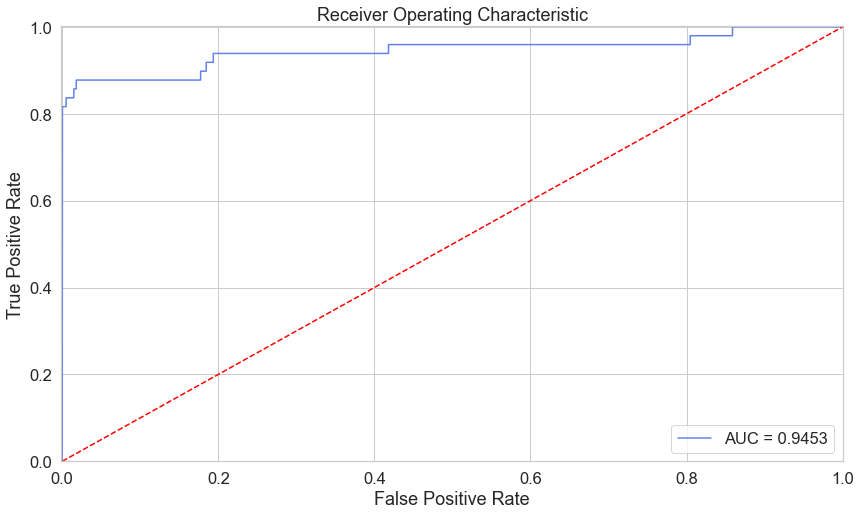

In [35]:
best_params = grid_result.best_params_
activation = best_params.get('activation')
optimizer = best_params.get('optimizer')
epochs = best_params.get('epochs')
batch_size = best_params.get('batch_size')
tuned_model = create_model(activation=activation, optimizer=optimizer)

tuned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tuned_model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid),
                        batch_size=batch_size,
                        epochs=epochs)

y_pred= tuned_model.predict(X_test)

# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# AUC
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)

print('roc-auc is {:.3f}'.format(roc_auc_score(Y_test, y_pred)))

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();